In [ ]:
print("Show Feature Map")

Show Feature Map


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model


1/1 [==============================] - 1s 673ms/step


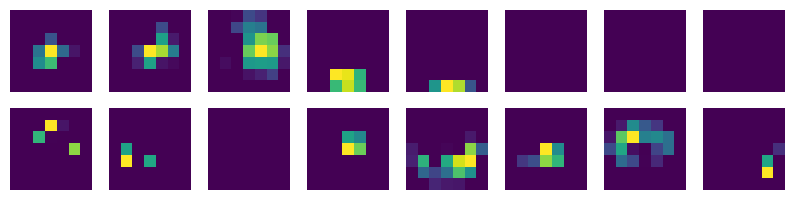

In [ ]:
base_model = load_model('/content/drive/MyDrive/Lung_Cancer_data/bioInfo_modelV1.h5')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

image_path = '/content/Malignant case (556).jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)


feature_maps = model.predict(img_array)


plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


In [ ]:
model.la

In [ ]:
base_model = load_model('/content/drive/MyDrive/Lung_Cancer_data/bioInfo_modelV1.h5')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('multiply_').output)

image_path = '/content/Malignant case (556).jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

feature_maps = model.predict(img_array)


plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


ValueError: ignored

1/1 [==============================] - 1s 1s/step


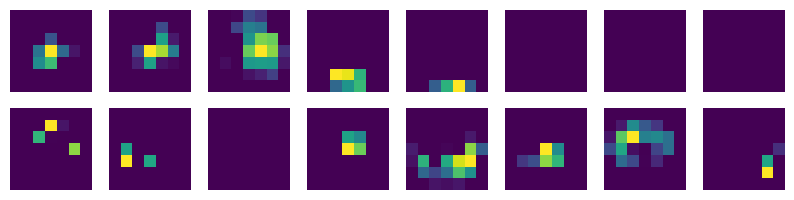

In [ ]:
base_model = load_model('/content/drive/MyDrive/Lung_Cancer_data/bioInfo_modelV1.h5')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('add_1').output)
# Load and preprocess an example image
image_path = '/content/Malignant case (556).jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Get the feature maps from the chosen layer
feature_maps = model.predict(img_array)

# Visualize the feature maps
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')  # You can choose a different colormap
    plt.axis('off')
plt.show()


HIRESCAM


In [ ]:
import os
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image, display

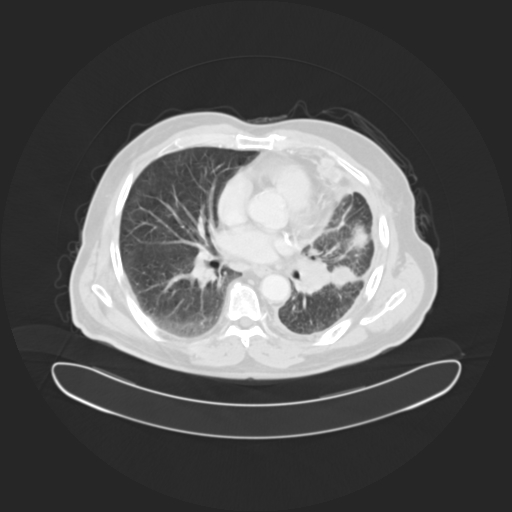

In [ ]:
model_builder = load_model('/content/drive/MyDrive/Lung_Cancer_data/bioInfo_modelV1.h5')
img_size = (224, 224)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions



# The local path to our target image
img_path = '/content/Malignant case (556).jpg'

display(Image(img_path))

In [ ]:
last_conv_layer_name = 'add_1'

In [ ]:
def load_img(img_path, size=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img


def get_img_array(img_path, size):
    img_array = load_img(img_path, size)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def get_preprocessed_img(img_path, size):
    img_array = get_img_array(img_path, size)
    return preprocess_input(img_array)

In [ ]:
def make_hirescam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Grad-CAM would introduce here a vector where each entry would be the mean
    # intensity of the gradient over a specific feature map channel (equivalent
    # to global average pooling)
    # pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # However, HiResCAM skips the gradient averaging step in order to retain
    # the relationship between the model explanation and the score calculation.

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class,
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output * grads
    heatmap = np.sum(heatmap, axis=-1)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 541ms/step


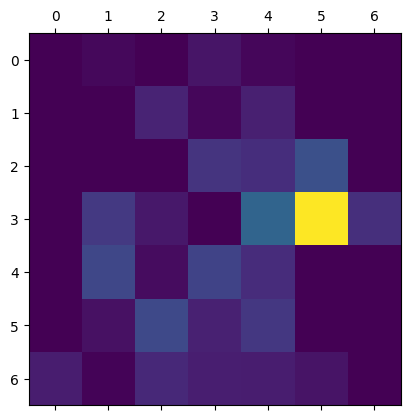

In [ ]:
# Prepare image
img_array = get_preprocessed_img(img_path, size=img_size)

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print('Predicted:', decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_hirescam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def resize_heatmap(img_path, heatmap):
    # Load the original image
    img = load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap('jet')

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    return jet_heatmap


resized_heatmap = resize_heatmap(img_path, heatmap)

<ipython-input-24-7c886c22555e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


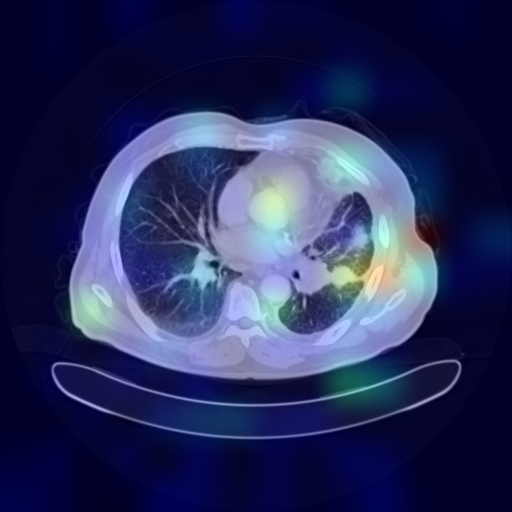

In [ ]:
def superimpose_heatmap(img, heatmap, alpha=0.4):
    superimposed_img = heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img)

    return superimposed_img


original_img = load_img(img_path)
superimposed_img = superimpose_heatmap(original_img, resized_heatmap)
display(superimposed_img)

<ipython-input-24-7c886c22555e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


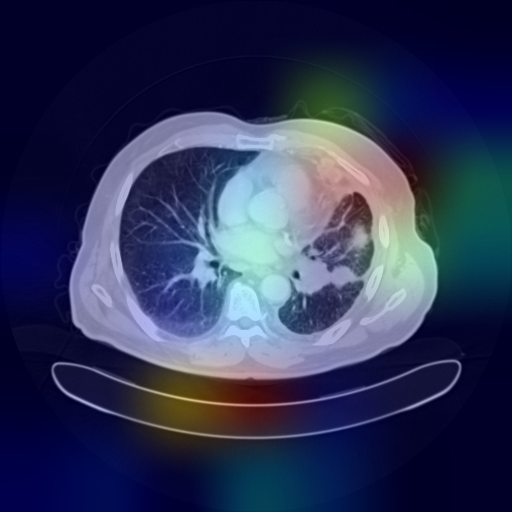

In [ ]:
img_path = '/content/Malignant case (556).jpg'
original_img = load_img(img_path)
heatmap = make_hirescam_heatmap(
    img_array, model, last_conv_layer_name, pred_index=2)

resized_heatmap = resize_heatmap(img_path, heatmap)
superimposed_img = superimpose_heatmap(original_img, resized_heatmap)
display(superimposed_img)

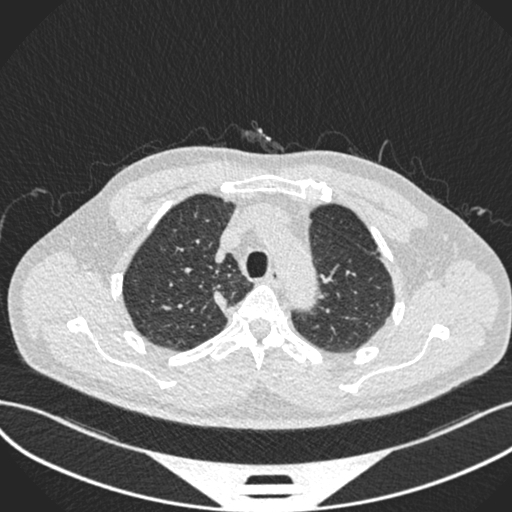

In [ ]:

img_path = '/content/Bengin case (119).jpg'
original_img = load_img(img_path)
display(Image(img_path))

<ipython-input-24-7c886c22555e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


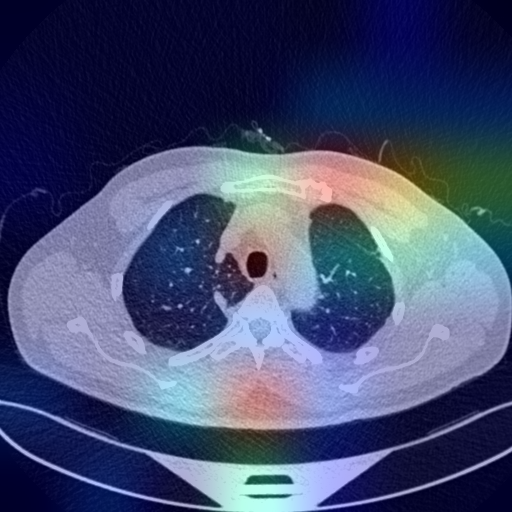

In [ ]:
img_array = get_preprocessed_img(img_path, size=img_size)
heatmap = make_hirescam_heatmap(
    img_array, model, last_conv_layer_name, pred_index=1)

resized_heatmap = resize_heatmap(img_path, heatmap)
superimposed_img = superimpose_heatmap(original_img, resized_heatmap)
display(superimposed_img)